[View in Colaboratory](https://colab.research.google.com/github/Rblivingstone/iMaterialist_Kaggle_competition/blob/master/notebook.ipynb)

In [2]:
!pip install kaggle
import keras
import pandas as pd
import numpy as np

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
 



Download 100%.


In [4]:
!kaggle competitions download -c imaterialist-challenge-fashion-2018 -w

test.json.zip: Skipping, found more recently modified local copy (use --force to force download)
validation.json.zip: Skipping, found more recently modified local copy (use --force to force download)
train.json.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from shutil import unpack_archive
unpack_archive('train.json.zip')


In [6]:
import json
print('okay')
json_data=open('train.json').read()
print('cool')
data = json.loads(json_data)
print(data['images'])

okay
cool


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
urls = [obj['url'] for obj in data['images']]
ids = [obj['imageId'] for obj in data['images']]

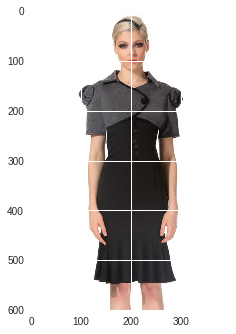

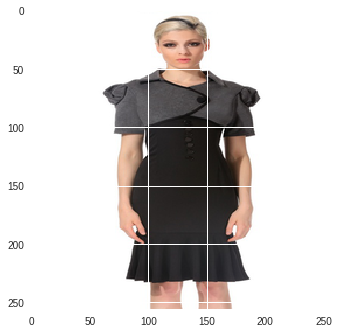

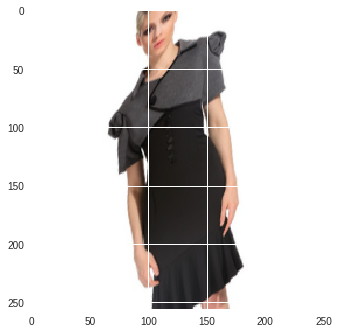

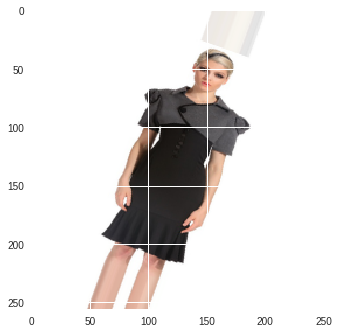

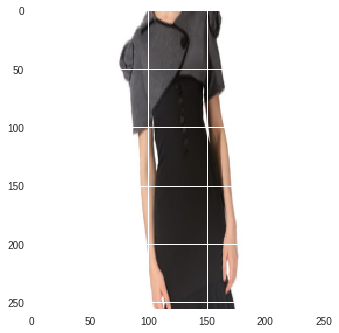

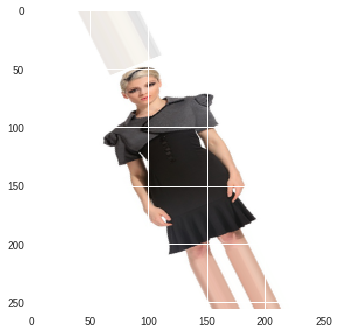

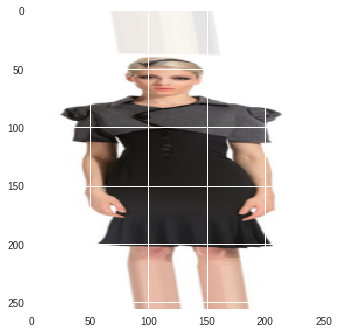

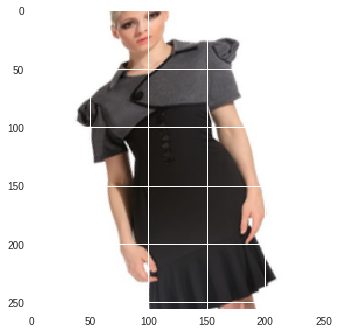

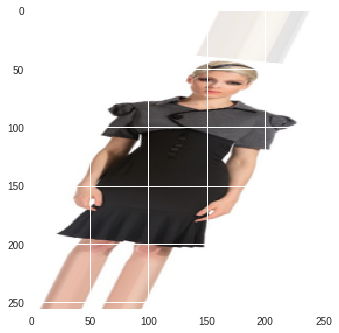

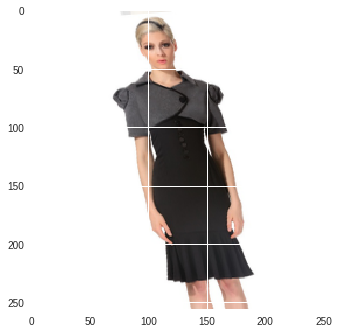

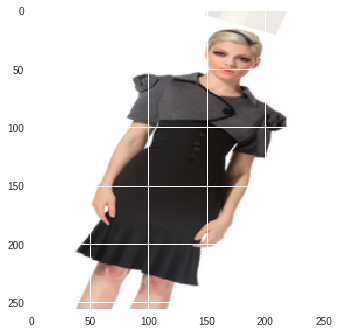

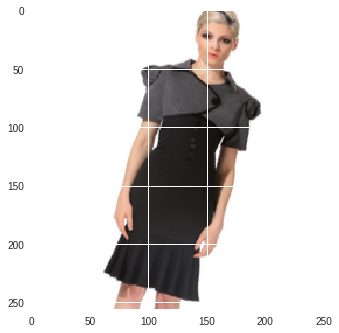

In [8]:
from urllib.request import urlopen	
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#import StringIO
size=(256,256)
idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
I = np.asarray(Image.open(img_file))
plt.imshow(I)
plt.show()

img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
im = Image.open(img_file)
im2 = im.resize(size, Image.ANTIALIAS)
im2.thumbnail(size, Image.ANTIALIAS)
I = np.asarray(im2)
plt.imshow(I)
plt.show()
idg_flow = idg.flow(I.reshape(1,256,256,3), batch_size=32)
for i in range(10):
  plt.imshow(idg_flow.next()[0])
  plt.show()

In [9]:
import numpy as np
output = []
for dat in data['annotations']:
  temp = [0]*228
  for obj in dat['labelId']:
    temp[int(obj)-1] = 1
  output.append(temp)
depvar = np.array(output)
print(depvar)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(256, 256, 3))
            )
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    #model.add(Activation('relu'))
    model.add(Dense(512))
    #model.add(Activation('relu'))
    model.add(Dense(228))
    #model.add(Activation('sigmoid'))
    print(model)
    return model
  


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from keras.models import load_model
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
d = load_model('model.h5')
#d = load_model('model.h5')
def generate_labels(array):
  output = []
  for row in array:
    temp = []
    for i in range(228):
      if row[i]>=0.5:
        temp.append(i+1)
    output.append(temp)
  return(output)

def convert_pic_to_data(url):
  try:
    img_file = urlopen(url)
    im = Image.open(img_file)
    
  except:
    output = [0]*(256*256*3)
    output = np.array(output).reshape(1,256,256,3)
    return(output)
    
  im2 = im.resize(size, Image.ANTIALIAS)
  im2.thumbnail(size, Image.ANTIALIAS)
  output = np.asarray(im2)
  return(output.reshape(1,256,256,3))

def label_maker(lookup_range=(0,1)):
  output = []
  for i in range(lookup_range[1]-lookup_range[0]):
    output.append({'id':i+1,'labels':generate_labels(d.predict(convert_pic_to_data(urls[lookup_range[0]+i])))})
  return(output)

#print(label_maker((5,10)))

In [0]:
from google.colab import files
from keras.models import load_model
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
d = load_model('model.h5')
#d = discriminator_model()

d_optim = Adamax(lr=0.1,epsilon=0.001)
d.compile(loss='mean_absolute_error', optimizer=d_optim)

idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
#np.random.seed(1825)
t=0
size = (256,256)
while t<100000:
  s = np.arange(320)
  np.random.shuffle(s)
  
  x=np.array([])
  y=np.array([])
  for j in range(10):
    #print(j)
    pix = np.random.randint(0,len(data['annotations']))
    
    try:
      img_file = urlopen(urls[pix])
      im = Image.open(img_file)
    except:
      next
    im2 = im.resize(size, Image.ANTIALIAS)
    im2.thumbnail(size, Image.ANTIALIAS)
    I = np.asarray(im2)
  #plt.imshow(I)
  #plt.show()
    idg_flow = idg.flow(I.reshape(1,256,256,3),np.array(depvar[pix]).reshape(1,228), batch_size=32)
    for i in range(32):
      tempx,tempy = idg_flow.next()
      x = np.append(x,tempx[0])
      y = np.append(y,tempy[0])
  d.fit(x.reshape(320,256,256,3),y.reshape(320,228),epochs=10)
  t+=1
  if t%10==0:
    #if t%1000==0:
    plt.imshow(I)
    plt.show()
    d.save('model.h5')
    print(generate_labels(d.predict(I.reshape(1,256,256,3))))
    print(np.sort([int(obj) for obj in data['annotations'][pix]['labelId']]).tolist())
    model.SetContentFile('model.h5')
    model.Upload()
  #  files.download('model.h5')
    

Epoch 1/10
320/320 [==============================] - 3s 10ms/step - loss: 0.0529
Epoch 2/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0523
Epoch 3/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0521
Epoch 4/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0523
Epoch 5/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0530
Epoch 6/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0529
Epoch 7/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0517
Epoch 8/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0522
Epoch 9/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0519
Epoch 10/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0526
Epoch 1/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0553
Epoch 2/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0543
Epoch 3/10
320/320 [======

320/320 [==============================] - 2s 5ms/step - loss: 0.0546
Epoch 6/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0541
Epoch 7/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0549
Epoch 8/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0550
Epoch 9/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0546
Epoch 10/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0545
Epoch 1/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0548
Epoch 2/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0553
Epoch 3/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0559
Epoch 4/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0557
Epoch 5/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0552
Epoch 6/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0552
Epoch 7/10
320/320 [==================

320/320 [==============================] - 2s 5ms/step - loss: 0.0549
Epoch 10/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0559
Epoch 1/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0544
Epoch 2/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0547
Epoch 3/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0543
Epoch 4/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0538
Epoch 5/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0543
Epoch 6/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0547
Epoch 7/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0540
Epoch 8/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0538
Epoch 9/10
320/320 [==============================] - 2s 5ms/step - loss: 0.0543
Epoch 10/10
320/320 [==============================] - 2s 6ms/step - loss: 0.0546
Epoch 1/10
320/320 [=================

In [0]:
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
